## Block covariance noise process

In this notebook, we use the block covariance noise process to fit a time series with an abrupt change in its noise terms.

First, we use Pints to generate a logistic growth model with two different noise regimes. The first half of the time series has autoregressive noise with a high correlation and low magnitude, while the second half has uncorrelated noise with a high magnitude.

In [1]:
import flexnoise
import matplotlib.pyplot as plt
import numpy as np
import pints
import pints.plot
import pints.toy

np.random.seed(222)

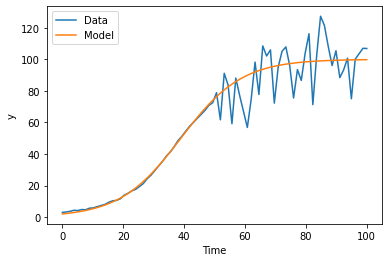

In [2]:
times = np.linspace(0, 100, 80)
model = pints.toy.LogisticModel()
real_parameters = [0.1, 100]

values = model.simulate(real_parameters, times)

noise1 = pints.noise.ar1(0.85, 1, 40)
noise2 = np.random.normal(0, 15, 40)

data = values + np.append(noise1, noise2)

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(times, data, label='Data')
ax.plot(times, values, label='Model')
ax.set_xlabel('Time')
ax.set_ylabel('y')
ax.legend()
plt.show()

As a preliminary run, we will try to learn the parameters of this model using the incorrect assumption of IID Gaussian noise. This is done using the Pints IID Gaussian likelihood. We place a uniform prior over both logistic model parameters and the noise variance $\sigma$.

In [3]:
problem = pints.SingleOutputProblem(model, times, data)
likelihood = pints.GaussianLogLikelihood(problem)
prior = pints.UniformLogPrior([0, 0, 0], [1e6, 1e6, 1e6])
posterior = pints.LogPosterior(likelihood, prior)

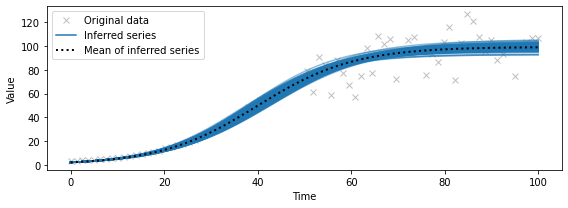

In [4]:
num_chains = 3
num_mcmc_iterations = 5000

starting_point = np.array([0.1, 100, 1])

x0 = []
for _ in range(num_chains):
    x0.append(np.random.normal(0, 0.1*starting_point) + starting_point)

mcmc = pints.MCMCController(posterior, num_chains, x0)
mcmc.set_max_iterations(num_mcmc_iterations)
mcmc.set_log_to_screen(False)
chains = mcmc.run()
iid_chain = chains[0][num_mcmc_iterations//2:]
pints.plot.series(iid_chain, problem)
plt.show()

Next, we run MCMC inference for the same Pints problem, using the block covariance method. This requires us to specify a flexnoise kernel as well as a prior over the model parameters.

In [5]:
kernel = flexnoise.kernels.LaplacianKernel
model_prior = pints.UniformLogPrior([0, 0], [1e6, 1e6])

We can then instantiate the block noise process and run MCMC inference. This step will simultaneously infer the model parameters and the noise blocks.

In [6]:
bnp = flexnoise.BlockNoiseProcess(
            problem, kernel, np.array([0.1, 100.0]), model_prior)

In [7]:
model_params_chain, cov_chain = bnp.run_mcmc(num_mcmc_iterations, iprint=False)
model_params_chain = np.array(model_params_chain)

The flexnoise library includes a plotting function for nonstationary noise fits. We use this to visualize the posterior of the block noise process.

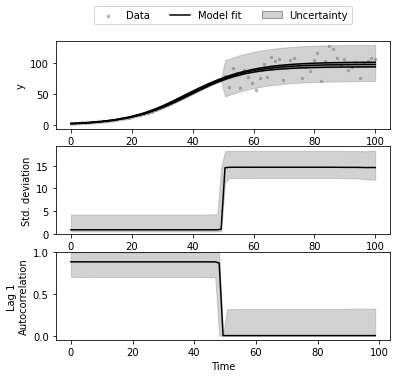

In [8]:
fig = flexnoise.plot.plot_nonstat_fit(
    problem,
    kernel=kernel(None),
    samples=model_params_chain.T,
    cov_samples=cov_chain,
    fname=None)

plt.show()

As seen in the figure, the noise process detects two blocks of noise. The first has a low magnitude and high correlation, while the second is uncorrelated with a higher magnitude. 